<a href="https://colab.research.google.com/github/r-o-h-a-n-2004/mask-rcnn-/blob/main/mak_rcnn_prebuilt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model loaded successfully
Inference complete
Detected 2 persons with confidence scores:
Person 1: Confidence=0.9999, Bounding Box=[0.336, 0.281, 0.806, 0.536]
Person 2: Confidence=0.9999, Bounding Box=[0.322, 0.754, 0.916, 0.957]


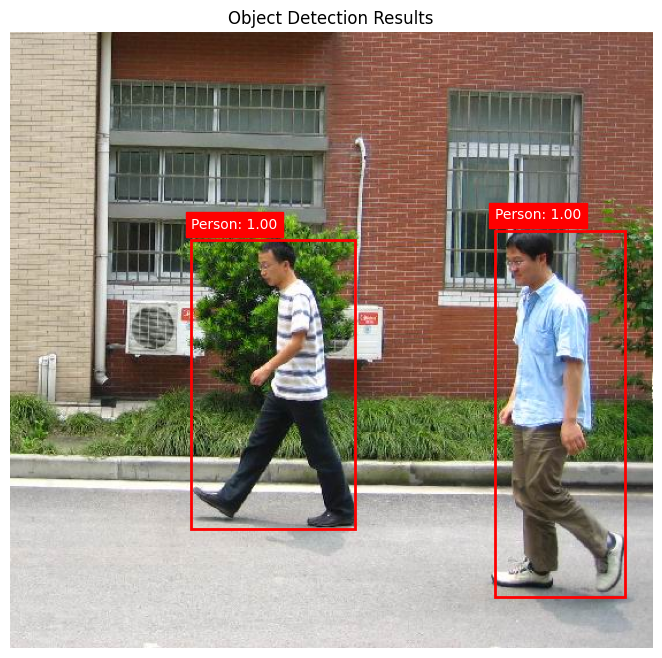

In [2]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import requests
import zipfile
import io

# Download and extract PennFudanPed dataset
def download_and_extract_dataset():
    url = "https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip"
    response = requests.get(url)
    zip_file = zipfile.ZipFile(io.BytesIO(response.content))
    zip_file.extractall()
    return "PennFudanPed"

# Load Mask R-CNN model from TensorFlow Hub
def load_model():
    model_url = "https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1"
    return hub.load(model_url)

# Process image for model input
def process_image(image_path, target_size=1024):
    image = Image.open(image_path).convert("RGB")
    original_size = image.size
    image = image.resize((target_size, target_size))
    return np.array(image), original_size

# Run object detection
def detect_objects(model, image):
    input_tensor = tf.convert_to_tensor(image)
    input_tensor = input_tensor[tf.newaxis, ...]  # Add batch dimension
    return model(input_tensor)

# Filter and process detections
def process_detections(result, confidence_threshold=0.7):
    boxes = result["detection_boxes"][0].numpy()
    scores = result["detection_scores"][0].numpy()
    classes = result["detection_classes"][0].numpy().astype(int)
    masks = result["detection_masks"][0].numpy() if "detection_masks" in result else None

    # Filter detections
    valid_indices = np.where((classes == 1) & (scores > confidence_threshold))[0]

    return {
        "boxes": boxes[valid_indices],
        "scores": scores[valid_indices],
        "classes": classes[valid_indices],
        "masks": masks[valid_indices] if masks is not None else None
    }

# Visualize results
def visualize_detections(image, detections, original_size):
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)

    target_size = image.shape[0]
    scale_x = original_size[0] / target_size
    scale_y = original_size[1] / target_size

    for box, score in zip(detections["boxes"], detections["scores"]):
        # Convert normalized coordinates to original image scale
        y1, x1, y2, x2 = box
        x1 = x1 * original_size[0]
        x2 = x2 * original_size[0]
        y1 = y1 * original_size[1]
        y2 = y2 * original_size[1]

        # Create rectangle patch
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=2, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)

        # Add confidence score
        ax.text(
            x1, y1 - 10, f"Person: {score:.2f}",
            color='white', fontsize=10, backgroundcolor='red'
        )

    plt.title("Object Detection Results")
    plt.axis('off')
    plt.show()

# Main execution
if __name__ == "__main__":
    # Setup dataset
    dataset_path = download_and_extract_dataset()
    img_dir = os.path.join(dataset_path, "PNGImages")
    sample_image = os.path.join(img_dir, "FudanPed00001.png")

    # Load model
    model = load_model()
    print("Model loaded successfully")

    # Process image
    image, original_size = process_image(sample_image)

    # Run detection
    result = detect_objects(model, image)
    print("Inference complete")

    # Process results
    detections = process_detections(result)
    print(f"Detected {len(detections['scores'])} persons with confidence scores:")
    for i, (score, box) in enumerate(zip(detections["scores"], detections["boxes"])):
        print(f"Person {i+1}: Confidence={score:.4f}, "
              f"Bounding Box=[{box[0]:.3f}, {box[1]:.3f}, {box[2]:.3f}, {box[3]:.3f}]")

    # Visualize results
    # Convert PIL Image to NumPy array before passing to visualize_detections
    visualize_detections(np.array(Image.open(sample_image)), detections, original_size)